# Polynomial Regression Example
The goal is to regress a function $f\in\mathbb R^\mathbb R$ given a training set $\mathcal D_n=\{(x_1,y_1),\ldots,(x_n,y_n)\}\subset\mathbb R^2$ consisting of $n$ data points.

Our target is the function $g(x)=\sin(2\pi x)$ restricted to $x\in[0,1]$. 



##Data generation

We assume that the data generation process is noisy. Specifically, given the desired number of datapoints $n$ we take them uniformly-spaced along the x-axis and apply a Gaussian perturbation along the $x$- and $y$-axes. In other terms, each datapoint $(x_i,y_i)$ with $i\in\{1,\ldots,n\}$ is given by 
$$
x_i = \frac{i-0.5}{n}+\delta_x\,,\qquad y_i=g(x_i)+\delta_y\,,
$$
where $\delta_x$ is a Gaussian random variable with zero mean and standard deviation $0.05$, while $\delta_y$ is a Gaussian random variable with zero mean and standard deviation $0.2$.

We start importing libraries that we will need.

In [2]:
# This imports the PyTorch library
import torch
# This imports the PI constant
from math import pi, sqrt, exp
# This imports the plotting library
import matplotlib.pyplot as plt

Next, we write a function that generates datasets according to the procedure mentioned above. We leave the $x$ and $y$ noise levels as parameters of the function. The function returns a $2$-tuple $(\boldsymbol x,\boldsymbol y)$ where $\boldsymbol x=\{x_1,\ldots,x_n\}$ and $\boldsymbol y=\{y_1,\ldots,y_n\}$

In [4]:
def generate_data(n, std_x=0, std_y=0):
  # Function to generate data according to the procedure described above
  #
  # n: number of points of the dataset
  # std_x (default 0) 
  #   standard deviation for the Gaussian perturbation along the x-axis
  # std_y (default 0)
  #   standard deviation for the Gaussian perturbation along the y-axis
  
  # This creates a 1D tensor with elements (i-0.5)/n, where i in {1,...,n}
  x = (torch.arange(1,n+1)-0.5)/n

  # This adds to x a vector of n random elements. Each element is sampled from 
  # a standard normal distribution (zero mean, unit variance) multiplied by 
  # std_x, which is equivalent to a Gaussian distribution with zero mean and 
  # standard deviation std_x
  x += torch.randn(n)*std_x
  
  # This computes the values of the target function g(x) in correspondence to 
  # the values in x
  y = (2*pi*x).sin_()

  # Similarly to x, this adds a random perturbations sampled from a Gaussian 
  # distribution with zero mean and standard deviation std_y
  y += torch.randn(n)*std_y

  # We return the generated datapoints as two 1D vectors, one for the x values
  # and one for the y values
  return (x,y)

We can now use this function to generate a plot of the target function $g(x)$. First we generate $n=100$ unperturbed data points.

In [5]:
# By using the function above with n=100 we obtain unperturbed, uniformly-spaced 
# points along the target function, which we will use to produce a plot of the 
# target function g(x)
xg,yg = generate_data(100)

Now, $\boldsymbol x_g$ and $\boldsymbol y_g$ hold the $x$- and $y$-values of $100$ uniformly-spaced points along the target function $g(x)$. Next, we plot them.

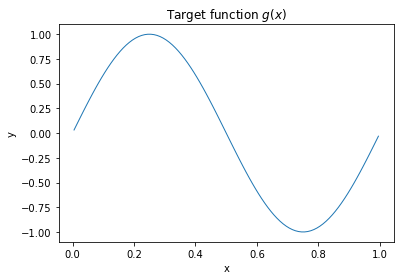

In [6]:
# This plots the points of g(x) generated above by connecting them with a line
# (this is the default behaviour of plot) and set the line thickness to 2
plt.plot(xg, yg, linewidth=1); 

# Next, we add some decorations to the plot, like labels for the axes 
# and a title
plt.xlabel('x'); plt.ylabel('y'); plt.title('Target function $g(x)$');

We generate a training set with $n=10$ points under the perturbation mentioned at the beginning of this document.

In [7]:
# We use generate_data to generate 10 perturbed 
xt,yt = generate_data(10, std_x=0.05, std_y=0.2)

Variables $\boldsymbol x_t$ and $\boldsymbol y_t$ hold the $x$ and $y$ coordinates of the training set, respectively. We can now plot the training set along with the target function $g(x)$.

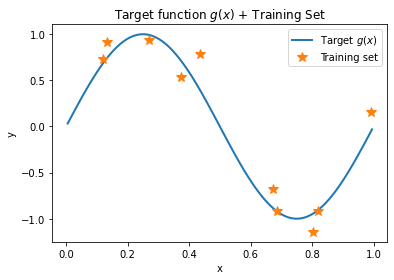

In [8]:
# This plots the curve with points with x-coordinates in xg and y-coordinates 
# in yg connected with a line ('-') and the points with x-coordinates in xt
# and y-coordinates in yt with a star ('*')
plt.plot(xg, yg, '-', xt, yt, '*', linewidth=2, markersize=10);

# Here we add x- and y-labels to the plot, a title and a legend
plt.xlabel('x'); plt.ylabel('y'); 
plt.title('Target function $g(x)$ + Training Set'); 
plt.legend(['Target $g(x)$','Training set']);

## Model hypotheses
To start, we need to determine a set of model hypotheses among which to search an optimal solution. We opt for polynomial functions of the form
$$f_\boldsymbol w(x)=\sum_{j=0}^M w_j x^j=w_0+w_1x+w_2x^2+\ldots+w_Mx^M\,,\tag{1}$$
where $\boldsymbol w=(w_0,\ldots,w_M)\in\mathbb R^{M+1}$ are model parameters. An implementation of $f_w$ is given below.

In [9]:
def polynomial(x,w):
  # Implementation of eq.(1).
  #
  # x: 1D tensor of size n with x-coordinates
  # w: a 1D tensor of size (M+1) with the w-parameters
  #    or a 2D tensor of size (M+1) x k
  # 
  # Return: if w is a 1D tensor it returns a 1D tensor of size n with f_w(x)
  #         if w is a 2D tensor it return a 2D tensor of size n x k, each 
  #          ith column holding the values f_w[:,i] (x)

  # This creates a 2D tensor X of size n x (M+1) where X_ij = x_i**j, x_i being
  # the ith element of x
  X=x.view(-1,1)**torch.arange(w.shape[0]).view(1,-1)

  # We matrix-multiply X and w, where w is either a 1D tensor or a 2D tensor
  return X.matmul(w)

We can now use the function above to plot some polynomials.


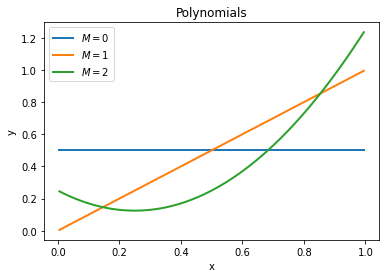

In [10]:
# We generate a 2D tensor where each column holds the w parameter of 
# a polynomial. Our goal is to provide 3 examples of polynomials of degree 0, 1 
# and 2, which are generated by the w-parameters [0.5,0.,0.], [0.,1.,0.] and 
# [0.25,-1.,2.], respectively.
W=torch.tensor([[0.5,0.,0.],[0.,1.,0.],[0.25,-1.,2.]]).t()

# This generates the y-coordinates of 3 polinomials using the parameters in W 
# and x-coordinates from xg
yp=polynomial(xg,W)

# Next we plot the 3 curves with y-coordinates in yp and x-coordinates in xg
plt.plot(xg,yp, linewidth=2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('Polynomials'); 
plt.legend(['$M=0$','$M=1$', '$M=2$']);

## Error function
The error function measures how much the prediction deviates from the ground-truth target. We measure the error in terms of mean squared error as follows:
$$
E(f_\boldsymbol w;\mathcal D_n)=\frac{1}{n}\sum_{i=1}^n[f_\boldsymbol w(x_i)-y_i]^2\,.
$$
Below, we provide an implementation of the error function that takes in input the ground-truth targets $\boldsymbol y_t$ and the ones predicted by $f_\boldsymbol w$, namely $\boldsymbol y_p$.

In [11]:
def error(yp, yt):
  # Function computing the error function E above
  #
  # yp: 1D tensor of size n holding predicted y-values
  #     or 2D tensor of size k x n holding predicted y-values for k models
  # yt: 1D tensor of size n holding target y-values

  return ((yp-yt)**2).mean(dim=-1)

## Training
The training procedure consists in finding the model hypothesis that minimizes the error function given above, i.e. we want to find $f_{\boldsymbol w^\star}$ where
$$
\boldsymbol w^\star\in\arg\min_{\boldsymbol w\in\mathbb R^{M+1}} E(f_\boldsymbol w;
\mathcal D_n)\tag{2}\,.
$$
By substituting the definition of $f_\boldsymbol w$ from $Eq.(1)$ we get
$$
E(f_\boldsymbol w;\mathcal D_n)=\frac{1}{n}\sum_{i=1}^n\left(\sum_{j=0}^M w_jx_i^j-y_i\right)^2\,.
$$
The optimization problem in $Eq.(2)$ is a so-called least-squares optimization problem, which can be rewritten in matrix form as follows
$$
E(f_\boldsymbol w;\mathcal D_n)=\frac{1}{n}\Vert X\boldsymbol w-\boldsymbol y_t\Vert^2\,,\tag{3}
$$
where $\Vert\cdot\Vert$ is the Euclidean norm, $X$ is a $n\times(M+1)$ matrix with entries $X_{ij}=x_i^j$ and $\boldsymbol y_t$ is a $n$-dimensional vector with the regression targets in the training set.
This can be easily solved in Pytorch using `torch.lstsq` (see [here](https://pytorch.org/docs/stable/torch.html#torch.lstsq)) as we show in the implementation below.

In [12]:
def train(xt,yt, M):
  # Function to estimate the w-parameters of a M-degrees polynomial given the 
  # training set with x-coordinates xt and y-coordinates yt
  #
  # xt: 1D tensor of size n with x-coordinates of the training set
  # yt: 1D tensor of size n with y-coordinates of the training set
  # M: polynomial degree

  # This creates a 2D tensor X of size n x (M+1) where X_ij = x_i**j, x_i being
  # the ith element of xt
  X=xt.view(-1,1)**torch.arange(M+1)

  # We solve the least squares optimization problem using torch.lstsq
  # Since it requires 2D tensors we view yt as a 2D tensor 
  solution, _ = torch.lstsq(yt.view(-1,1),X)

  # lstsq always returns a tensor with first dimension of size n, despite the 
  # solution being in the first M+1 elements. Accordinly, we slice the solution
  # by preserving the first M+1 elements. We also squeeze the last dimension, 
  # which we added to use lstsq
  return solution[:X.shape[1]].squeeze(-1)

We train now different models for different degrees of the polynomial. Specifically, we will train models with degree $M\in\{0,\ldots,9\}$ and keep them in a list `trained_models`. And compute the predictions on $\boldsymbol x_g$ (100 uniformly distributed noiseless points) to get plottable curves.

In [13]:
# This trains 10 models, one for each polynomial degree m in the range {0,...,9}
# The trained w-parameters are stored in a list
trained_models = [train(xt,yt,M) for M in range(10)]

# This computes curves of the trained polynomials for visualization purposes.
# The curves are computed using the x-coordinates in xg and stored in a list
curves=[polynomial(xg,w) for w in trained_models]

# This stacks the curves together in a 2D tensor of size 100 x 10 
# (number of points on each curve times the number of curves )
curves=torch.stack(curves,dim=-1)

We will now visualize some of the trained models, namely the ones with degree $M\in\{0,1,3,9\}$.

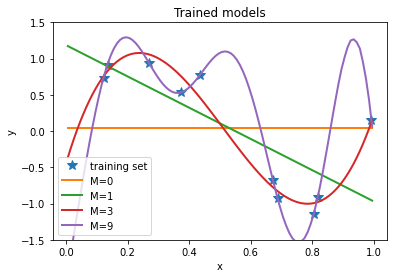

In [14]:
# We create a list of polynomial degrees M we want to visualize
M_to_visualize=[0,1,3,9]

# We filter the polynomial curves we have computed before by retaining only the
# ones we are interested in visualizing
yp=curves[:,M_to_visualize]

# This plots the training set as a set of points (marked with stars) and the 
# estimanted polynomials as piecewise linear curves
plt.plot(xt,yt,'*',xg, yp, linewidth=2, markersize=10); 

# We add plot decorations and limit the y-range for better visualization
plt.ylim([-1.5,1.5]); 
plt.xlabel('x'); plt.ylabel('y'); plt.title('Trained models');

# The legend is automatically populated using the list of polynomial degrees
plt.legend(['training set']+['M={}'.format(M) for M in M_to_visualize]);

We visualize now the training error for the different trained models. To this end we need to compute predictions on $\boldsymbol x_t$ and then use the error function implemented above to obtain error curves to plot. We will write a function for the generation of the error curves, because it will be needed also later on.

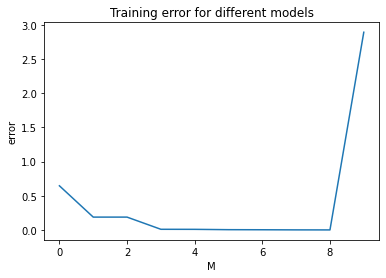

In [13]:
def compute_errors(x, y, trained_models):
  # Function to compute the error value for each trained model on the given 
  # x-coordinates
  #
  # x: 1D tensor of size n of x-coordinates
  # y: 1D tensor of size n of target y-coordinates
  # trained_models: a list of size k of w-parameters of trained models

  # This computes the y-coordinates of each trained model on the x and stores
  # the result in a list
  yp=[polynomial(x,w) for w in trained_models]

  # We stack all curves in a 2D tensor of size k x n (number of  models times 
  # number of points)
  yp=torch.stack(yp, dim=0)

  # We finally compute the errors from the predicted y-coordinates and the
  # target y-coordinates
  return error(yp,y)

# This uses the function above to compute the training error of the trained 
# models
training_errors=compute_errors(xt, yt, trained_models)

# This plots the training errors of the different models as a function of the 
# polynomial degree
plt.plot(range(10), training_errors);
plt.xlabel('M'); plt.ylabel('error'); 
plt.title('Training error for different models');

##Validation
Inspecting curves of the training error do not give indication about the generalization capabilities of our models, since those are selected minimizing the training error and the higher the degree of the polynomial, the lower the training error will be. So we need to generate a new independent dataset (**validation set**) from our data distribution that we use to select the best model. We assume to generate a validation set with $10$ points as the training data.

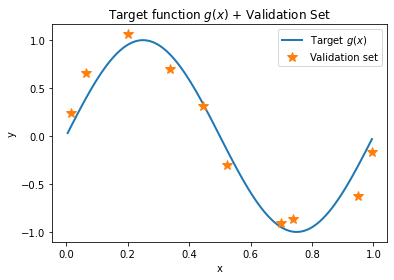

In [14]:
# This generates a 10-points validation set under the same data generation 
# process used to sample the training set
xv,yv=generate_data(10, std_x=0.05, std_y=0.2)

# This plots the curve with points with x-coordinates in xg and y-coordinates 
# in yg connected with a line ('-') and the points with x-coordinates in xt
# and y-coordinates in yt with a star ('*')
plt.plot(xg, yg, '-', xv, yv, '*', linewidth=2, markersize=10);

# Here we add x- and y-labels to the plot, a title and a legend
plt.xlabel('x'); plt.ylabel('y'); 
plt.title('Target function $g(x)$ + Validation Set'); 
plt.legend(['Target $g(x)$','Validation set']);

We can follow the same procedure above and compute the error curves for the validation set that we can then plot together with the training error curves.

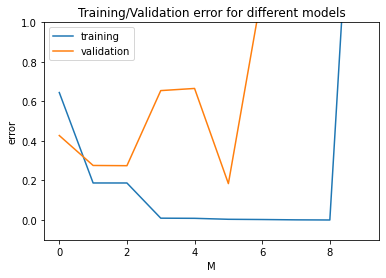

In [15]:
# We compute the error on the validation set as a surrogate for the 
# generalization error obtained by the trained models
validation_errors=compute_errors(xv,yv, trained_models)

# We plot the validation error along with the training error of the trained 
# models, by limiting the y-axis for better visualization
plt.plot(range(10), training_errors, '-',range(10), validation_errors,'-');
plt.ylim([-0.1,1]); plt.xlabel('M'); plt.ylabel('error'); 
plt.title('Training/Validation error for different models');
plt.legend(['training','validation']);

## Regularized training
In this section we consider a regularized error function, which allows to encode in a regularization function $\Omega$ a smoothness prior in order to prefer slow-varying functions over fast-varying ones. Smooth polynomials are the ones with a low-magnitude gradient. A way of measuring the smoothness of a polynomial is by computing the norm of the weights $w$. Accordingly, a widely used regularization term is given by
$$\Omega(w)=\frac{1}{2}\Vert w\Vert^2=\frac{1}{2}\sum_{j=0}^{M} w_j^2\,.$$
The regularized error function becomes:
$$
E_\text{reg}(f_\boldsymbol w; \mathcal D_n)=E(f_\boldsymbol w; \mathcal D_n)+\frac{\lambda}{n}\Omega(w)\,.
$$
This remains a quadratic problem that can be rewritten in matrix form as follow:
$$
E_\text{reg}(f_\boldsymbol w;\mathcal D_n)=\frac{1}{n}\Vert X\boldsymbol w-\boldsymbol y_t\Vert^2+\frac{\lambda}{n}\Vert w\Vert^2=\frac{1}{n}\left\Vert \begin{bmatrix}X\\
\sqrt{\lambda} I
\end{bmatrix}
\boldsymbol w-
\begin{bmatrix}
\boldsymbol y_t\\
\boldsymbol 0
\end{bmatrix}
\right\Vert^2\,.\tag{4}
$$
Accordingly, we have still a least-squares optimization problem that we can solve via `torch.lstsq`. The updated training function is given below.

In [16]:
def train_reg(xt,yt, M, l):
  # Function to estimate the w-parameters of a M-degrees polynomial given the 
  # training set with x-coordinates xt and y-coordinates yt
  #
  # xt: 1D tensor of size n with x-coordinates of the training set
  # yt: 1D tensor of size n with y-coordinates of the training set
  # M: polynomial degree
  # l: regularization parameter

  # This creates a 2D tensor X of size n x (M+1) where X_ij = x_i**j, x_i being
  # the ith element of xt
  X=xt.view(-1,1)**torch.arange(M+1)

  # We concatenate X and sqrt(l)I, where I is the identity matrix of size 
  # m+1 that can be constructed with torch.eye(M+1)
  X=torch.cat([X, sqrt(l)*torch.eye(M+1)],dim=0)

  # We concatenate yt and a vector of zeros of size m+1
  yt=torch.cat([yt, torch.zeros(M+1)],dim=0)

  # We solve the least squares optimization problem using torch.lstsq
  # Since it requires 2D tensors we view yt as a 2D tensor 
  solution, _ = torch.lstsq(yt.view(-1,1),X)

  #lstsq always returns a tensor with first dimension of size n, despite the 
  # solution being in the first M+1 elements. Accordinly, we slice the solution
  # by preserving the first M+1 elements. We also squeeze the last dimension, 
  # which we added to use lstsq
  return solution[:X.shape[1]].squeeze(-1)

We train different models with polynomial degree $M=9$ with different regularization parameter $\lambda$. Specifically, we will train 10 models with $\lambda\in\{e^{-2j}\}_{j=0}^9$ and keep them in a list `trained_reg_models`. And compute the predictions on $\boldsymbol x_g$ (100 uniformly distributed noiseless points) to get plottable curves. We will then visualize the curves curresponding to $\lambda\in\{e^{-36}, e^{-24}, e^{-12}, 1\}$.

In [17]:
# We will train 10 models using the lambda values e**-2j for j in {0,...,9}
# We keep the lambad logarithms in the list below
log_lambdas=[-4*j for j in range(10)] 
# NOTE: in the video I had -2*j and switched to -4*j afterwards to better 
# highlight some extreme cases (see video)

# This trains 3 models with degree M=9, one for each lambda value.
# The trained w-parameters are stored in a list
trained_reg_models = [train_reg(xt,yt,9,exp(l)) for l in log_lambdas]

# This computes curves of the trained polynomials for visualization purposes.
# The curves are computed using the x-coordinates in xg and stored in a list
curves_reg=[polynomial(xg,w) for w in trained_reg_models]

# This stacks the curves together in a 2D tensor of size 100 x 10 
# (number of points on each curve times the number of curves )
curves_reg=torch.stack(curves_reg,dim=-1)

We will now visualize the trained models.

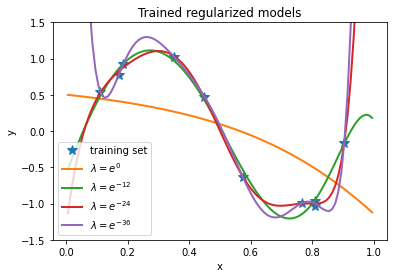

In [18]:
# We put in a list the indices of the curves to visualize, i.e. the ones obtained
# with log_lambdas {-36, -24, -12, 0}
idx_to_visualize=[0, 3, 6, 9]

# This plots the training set as a set of points (marked with stars) and the 
# selected curves as piecewise linear curves
plt.plot(xt,yt,'*',xg, curves_reg[:,idx_to_visualize], linewidth=2, markersize=10); 

# We add plot decorations and limit the y-range for better visualization
plt.ylim([-1.5,1.5]); 
plt.xlabel('x'); plt.ylabel('y'); plt.title('Trained regularized models');

# The legend is automatically populated using the list of polynomial degrees
plt.legend(['training set']+['$\lambda=e^{{{}}}$'.format(log_lambdas[j]) for j in idx_to_visualize]);

We visualize now the training error for the trained regularized models. To this end we need to compute predictions on $\boldsymbol x_t$ and then use the error function to obtain error curves to plot. 

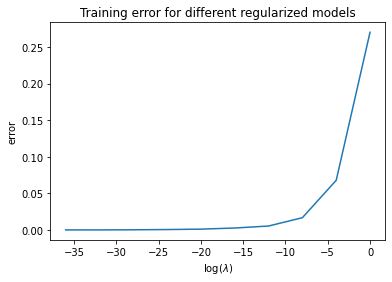

In [19]:
# This uses the function above to compute the training error of the trained 
# models
training_reg_errors=compute_errors(xt, yt, trained_reg_models)

# This plots the training errors of the different models as a function of 
# log(lambda)
plt.plot(log_lambdas, training_reg_errors);
plt.xlabel('$\log(\lambda)$'); plt.ylabel('error'); 
plt.title('Training error for different regularized models');

## Validation of regularized models

We can follow the same procedure above and compute the error curves for the validation set that we can then plot together with the training error curves.

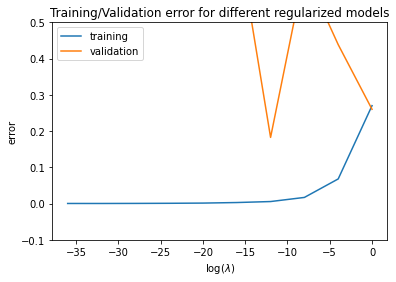

In [20]:
# We compute the error on the validation set as a surrogate for the 
# generalization error obtained by the trained regularized models
validation_reg_errors=compute_errors(xv,yv, trained_reg_models)

# We plot the validation error along with the training error of the trained 
# models, by limiting the y-axis for better visualization
plt.plot(log_lambdas, training_reg_errors, '-',log_lambdas, validation_reg_errors,'-');
plt.ylim([-0.1,0.5]); plt.xlabel('$\log(\lambda)$'); plt.ylabel('error'); 
plt.title('Training/Validation error for different regularized models');
plt.legend(['training','validation']);

## Using scikit-learn
Scikit-learn is a Python library that implements several machine learning algorithms, including regularized linear regression (see [here](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares) for ordinary least-squares regression and [here](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification) for the regularized version). We will now use the library to address the polynomial regression task.

We start by importing the necessary libraries.

In [21]:
from sklearn import linear_model

We create a linear regressor object using [`linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression). 

In [22]:
model_sl = linear_model.LinearRegression(fit_intercept=False)

Note that we set fit_intercept to `False` because it would otherwise estimate an additional constant term which already exists in our model, being $w_0$.

We write now a training function akin to the one we have written already, but this time working with scikit-learn models.

In [23]:
def train_sl(model_sl, xt,yt, M):
  # Function to fit a M-degrees polynomial given the training set with
  # x-coordinates xt and y-coordinates yt, and using a scikit-learn regressor.
  #
  # model_sl: scikit-learn regressor
  # xt: 1D tensor of size n with x-coordinates of the training set
  # yt: 1D tensor of size n with y-coordinates of the training set
  # M: polynomial degree

  # This creates a 2D tensor X of size n x (M+1) where X_ij = x_i**j, x_i being
  # the ith element of xt
  X=xt.view(-1,1)**torch.arange(M+1)

  # This trains the model given the training set.
  # The trained model is encapsulated into the model_sl object
  model_sl.fit(X,yt)

We use the function above to train a polynomial of degree $M=3$ on our training set, since we already found it to be a good model hypothesis for the regression task under study.

In [24]:
train_sl(model_sl, xt,yt,M=3)

We can inspect the $\boldsymbol w$-parameter of the trained model using the attributes `coef_` and compare against the one we estimated already, i.e. `trained_models[3]`.

In [25]:
print("w-parameters estimated with scikit-learn: {}".format(model_sl.coef_))
print("w-parameters estimated with PyTorch: {}".format(trained_models[3]))

w-parameters estimated with scikit-learn: [ -1.4449117  22.897982  -59.97992    40.04883  ]
w-parameters estimated with PyTorch: tensor([ -1.4449,  22.8980, -59.9799,  40.0488])


As expected we obtain basically the same model, up to very small numerical differences.

Once the model is trained we can use the function [`predict`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict) to evaluate the trained model on new data. We create an alterative version of the previously-defined function `polynomial`, in order to use `predict`.

In [26]:
def polynomial_sl(model_sl, x):
  # Implementation of eq.(1) using a trained model with scikit-learn.
  #
  # reg: trained polynomial regressor using scikit-learn
  # x: 1D tensor of size n with x-coordinates
  # 

  # This creates a 2D tensor X of size n x (M+1) where X_ij = x_i**j, x_i being
  # the ith element of x. Note that we infer (M+1) from the length of coef_ of
  # the LinearRegression object
  X=x.view(-1,1)**torch.arange(len(model_sl.coef_)).view(1,-1)

  return model_sl.predict(X)

We can now use the function above to evaluate the model on $\boldsymbol x_g$ and plot the result along with the original target function and the training set.

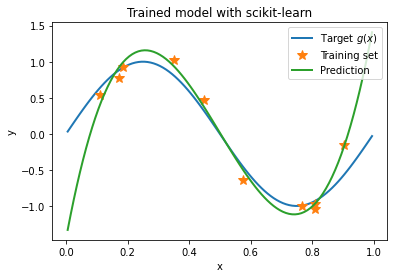

In [27]:
yp_sl = polynomial_sl(model_sl, xg)
plt.plot(xg, yg, '-', xt,yt,'*', xg, yp_sl, '-', linewidth=2, markersize=10);
plt.ylabel('y'); plt.xlabel('x'); plt.title('Trained model with scikit-learn');
plt.legend(['Target $g(x)$', 'Training set', 'Prediction']);

### Regularized version
We can train a $\ell_2$-regularized polynomial regressor (see Eq.(4)) using the scikit-learn class [linear_model.Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn-linear-model-ridge), which accepts also as parameter the value of $\lambda$ (actually $\alpha$ in scikit-learn).

As an example, we create a regularized linear regressor with $\lambda=e^{-8}$.

In [28]:
model_reg_sl = linear_model.Ridge(alpha=exp(-8), fit_intercept=False)

We can then use the `train_sl` function to fit a regularized polynomial regressor on the training data with degree $M=9$.

In [29]:
train_sl(model_reg_sl, xt, yt, M=9)

# Here we compare the w-parameters trained with scikit-learn and the ones we
# have trained under the same setting with PyTorch (trained_reg_models[2])
print("w-parameters estimated with scikit-learn: {}".format(model_reg_sl.coef_))
print("w-parameters estimated with PyTorch: {}".format(trained_reg_models[2]))

w-parameters estimated with scikit-learn: [-1.03950815e-02  7.16993313e+00 -1.20049508e+01 -6.71080291e+00
  1.56040812e+00  5.65960635e+00  5.71405921e+00  3.41981813e+00
  2.23102185e-01 -2.98400376e+00]
w-parameters estimated with PyTorch: tensor([-1.0396e-02,  7.1699e+00, -1.2005e+01, -6.7108e+00,  1.5604e+00,
         5.6596e+00,  5.7140e+00,  3.4198e+00,  2.2309e-01, -2.9840e+00])


We can now plot the trained model along with the original target function and the training set.

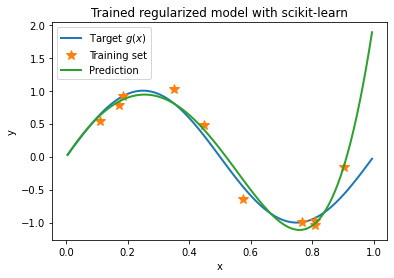

In [30]:
yp_reg_sl = polynomial_sl(model_reg_sl, xg)
plt.plot(xg, yg, '-', xt,yt,'*', xg, yp_reg_sl, '-', linewidth=2, markersize=10);
plt.ylabel('y'); plt.xlabel('x'); plt.title('Trained regularized model with scikit-learn');
plt.legend(['Target $g(x)$', 'Training set', 'Prediction']);

## Generalization Vs data size
To conclude, we will see that if we have a large enough data sample, we are able to fit the target function $g(x)$ in the range $[0,1]$ also with large polynomial degrees. We will consider polynomials of degree of $M=15$ and a training set with $1000$ points. 

We start generating the training set and train a polynomial regressor using scikit-learn.

In [31]:
# We generate the large training set with 1000 perturbed points
xt_large, yt_large =  generate_data(1000, std_x=0.05, std_y=0.2)

# We create the linear regressor object
another_model_sl = linear_model.LinearRegression(fit_intercept=False)

# We train a polynomial regressor
train_sl(another_model_sl, xt_large, yt_large, M=15)

We can now plot the trained model along with the original target function and the training set.

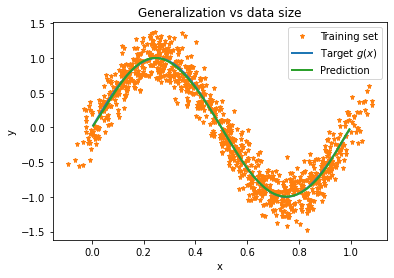

In [32]:
yp_sl_large = polynomial_sl(another_model_sl, xg)
lines=plt.plot(xt_large,yt_large,'*', xg, yg, '-',xg, yp_sl_large, '-', linewidth=2, markersize=5);
# The following two lines fix the colors after having swapped the training set
# and the target curves in the plotting order. The reason of the swap is to prevent
# the training set points from covering the target curve.
lines[0].set_color('C1')
lines[1].set_color('C0')
plt.ylabel('y'); plt.xlabel('x'); plt.title('Generalization vs data size');
plt.legend(['Training set', 'Target $g(x)$', 'Prediction']);

As we can see, the target function $g(x)$ and the estimated model are almost indistinguishable now, despite the misspecification of the polynomial degree. This is due to the large size of the training set, which gets closer to the true data distribution.